In [ ]:
pip install -r ../requirements.txt

In [43]:
# ============================================================================
# SECTION 1: DATA LOADING AND BASIC INFO
# ============================================================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('../data/IndeedJobScraperIntern.csv')

# Basic dataset info
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"Total jobs: {len(df)}")
print(f"Columns: {len(df.columns)}")
print(f"\nDate range:")
df['Posted_Date'] = pd.to_datetime(df['Posted_Date'], errors='coerce')
print(f"  From: {df['Posted_Date'].min()}")
print(f"  To: {df['Posted_Date'].max()}")
print(f"  Span: {df['Posted_Date'].max() - df['Posted_Date'].min()}")


DATASET OVERVIEW
Total jobs: 474
Columns: 20

Date range:
  From: 2024-11-22 17:12:56.219000+00:00
  To: 2025-12-17 12:53:19.602000+00:00
  Span: 389 days 19:40:23.383000


In [44]:
# ============================================================================
# SECTION 2: SKILLS DEFINITION
# ============================================================================

# Define skills by category
skills = {
    'Programming': ['Python', 'SQL', 'R', 'Julia', 'Rust', 'Scala', 'Java', 'C++', 'C#', 'Kotlin', 'Go', 'Pyspark', 
                    'JavaScript', 'TypeScript', 'Git'],
    'Mathematics & Statistics': ['Linear Algebra', 'Calculus', 'Probability', 'Statistics', 'Bayesian Inference', 
                                 'Optimization', 'Resampling', 'Cross-validation', 'Bootstrapping', 'Matrix operations', 
                                 'Partial derivatives'],
    'Machine Learning': ['Machine Learning','Supervised Learning', 'Unsupervised Learning', 'Deep Learning', 'Reinforcement Learning', 
                         'Reinforcement Learning (RL)', 'RL', 'XGBoost', 'CatBoost', 'Random Forest', 'CNN', 'RNN', 
                         'Transformers', 'SVM'],
    'AI Agents & Generative AI': ['AI Agents', 'Agentic AI', 'Multi-agent systems', 'LLMs', 'NLP', 'Prompt Engineering', 
                                  'Retrieval-Augmented Generation', 'RAG', 'Model Context Protocol', 'MCP', 
                                  'Agent-to-Agent', 'A2A', 'A2A protocols', 'Fine-tuning', 'Token optimization', 
                                  'Context management', 'Agent hierarchies'],
    'Agentic Frameworks & Tools': ['LangChain', 'CrewAI', 'AutoGen', 'LangGraph', 'AutoGPT', 'LlamaIndex', 
                                   'Microsoft Semantic Kernel', 'OpenAI Swarm', 'Vercel AI SDK', 'DSPy', 
                                   'Amazon Bedrock AgentCore', 'Hugging Face Transformers Agents', 'Langflow'],
    'Causal Inference & Experimentation': ['A/B Testing', 'Geo Experiments', 'Difference-in-Differences', 'DiD', 
                                            'Synthetic Control', 'Instrumental Variables', 'Propensity Score Matching', 
                                            'Uplift Modeling', 'Quasi-experimental design'],
    'Data Engineering & MLOps': ['ETL', 'ELT', 'ETL/ELT', 'Docker', 'Kubernetes', 'Apache Spark', 'Spark', 'Kafka', 
                                 'Airflow', 'dbt', 'MLflow', 'CI/CD', 'MLOps', 'Model monitoring', 'Observability', 
                                 'Tracing', 'AI Guardrails', 'Red-teaming'],
    'Database Systems': ['PostgreSQL', 'MySQL', 'Agentic Postgres', 'NoSQL', 'MongoDB', 'Cassandra', 'Redis', 'Neo4j', 
                        'Snowflake', 'BigQuery', 'Vector Databases', 'Pinecone', 'Milvus', 'Weaviate', 'Qdrant', 
                        'Chroma', 'FAISS', 'Databricks'],
    'Visualization & BI': ['Tableau', 'Power BI', 'Looker', 'D3.js', 'Plotly', 'Dash', 'Matplotlib', 'Seaborn', 
                          'Streamlit'],
    'Cloud': ['AWS', 'Amazon Web Services', 'Azure', 'Microsoft Azure', 'Google Cloud', 'GCP', 'Google Cloud Platform'],
    'Professional Skills & Ethics': ['Communication', 'Data Storytelling', 'Data Analysis', 'Analyze Data', 
                                    'Responsible AI', 'Ethical Governance', 'GDPR 2.0', 
                                    'AI Act compliance', 'Domain Expertise', 'Cross-functional collaboration', 
                                    'Problem-solving', 'Critical Thinking']
}

# Define skill aliases/synonyms - skills that should be counted together as one
# Key is the primary skill name, value is list of aliases (including the primary name)
skill_aliases = {
    'Data Analysis': ['Data Analysis', 'Data Analytics']  # Count both as "Data Analysis"
}

# ============================================================================
# SECTION 3: SKILL COUNTING FUNCTION
# ============================================================================

# Helper function: Check if skill appears in text
def check_skill_in_text(text, skill):
    """Check if skill appears in text (case-insensitive, word boundaries)"""
    pattern = r'\b' + re.escape(skill) + r'\b'
    return bool(re.search(pattern, str(text), re.IGNORECASE))

# Prepare skills list
all_skills = []
for category, skill_list in skills.items():
    for skill in skill_list:
        all_skills.append((skill, category))

# Count skills in job descriptions
# Note: Each skill counted only once per job, even if mentioned multiple times
def count_skill_frequency(df, skills_list):
    skill_counts = {}
    total_jobs = len(df)
    
    # Get all Full_Description texts
    descriptions = df['Full_Description'].fillna('').astype(str)
    
    # First, handle skills with aliases
    for primary_skill, aliases in skill_aliases.items():
        # Find the category for the primary skill
        category = None
        for skill, cat in skills_list:
            if skill == primary_skill:
                category = cat
                break
        
        if category:
            # Check for any of the aliases in each job description
            # If any alias is found, count it as the primary skill
            pattern_parts = [r'\b' + re.escape(alias) + r'\b' for alias in aliases]
            combined_pattern = '|'.join(pattern_parts)
            count = descriptions.str.contains(combined_pattern, case=False, na=False, regex=True).sum()
            skill_counts[primary_skill] = {
                'count': count,
                'percentage': (count / total_jobs * 100) if total_jobs > 0 else 0,
                'category': category
            }
    
    # Then, handle regular skills (excluding those that are aliases)
    alias_skills = set()
    for aliases in skill_aliases.values():
        alias_skills.update(aliases)
    
    for skill, category in skills_list:
        # Skip if this skill is an alias (already counted above)
        if skill not in alias_skills:
            # Create regex pattern with word boundaries for exact matches
            # Handle special characters in skill names
            pattern = r'\b' + re.escape(skill) + r'\b'
            # str.contains() returns True if skill found (once or multiple times), False otherwise
            # .sum() counts how many job postings have True (i.e., contain the skill at least once)
            # This ensures each skill is counted only once per job posting
            count = descriptions.str.contains(pattern, case=False, na=False, regex=True).sum()
            skill_counts[skill] = {
                'count': count,
                'percentage': (count / total_jobs * 100) if total_jobs > 0 else 0,
                'category': category
            }
    
    return skill_counts

# ============================================================================
# SECTION 4: CALCULATE SKILL FREQUENCIES
# ============================================================================

# Count all skills
skill_frequencies = count_skill_frequency(df, all_skills)

# Create results DataFrame
skill_df = pd.DataFrame([
    {
        'Skill': skill,
        'Category': info['category'],
        'Count': info['count'],
        'Percentage': info['percentage']
    }
    for skill, info in skill_frequencies.items()
])
skill_df = skill_df.sort_values('Count', ascending=False)

# Display results
print("=" * 80)
print("SKILL FREQUENCY ANALYSIS")
print("=" * 80)
print(f"\nTotal jobs analyzed: {len(df)}")
print(f"Total unique skills searched: {len(all_skills)}\n")

# Display top skills overall
print("\n" + "=" * 80)
print("TOP 20 MOST FREQUENT SKILLS")
print("=" * 80)
print(skill_df.head(20).to_string(index=False))

# Display by category
print("\n" + "=" * 80)
print("SKILL FREQUENCIES BY CATEGORY")
print("=" * 80)

for category in skills.keys():
    category_skills = skill_df[skill_df['Category'] == category].sort_values('Count', ascending=False)
    if len(category_skills) > 0:
        print(f"\n{category}:")
        print("-" * 80)
        print(category_skills.to_string(index=False))
        print(f"\nTotal mentions in {category}: {category_skills['Count'].sum()}")
        print(f"Average percentage per skill: {category_skills['Percentage'].mean():.2f}%")

# Summary statistics
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)
print(f"\nTotal skill mentions: {skill_df['Count'].sum()}")
print(f"Average mentions per skill: {skill_df['Count'].mean():.2f}")
print(f"Median mentions per skill: {skill_df['Count'].median():.2f}")
print(f"Skills with 0 mentions: {(skill_df['Count'] == 0).sum()}")
print(f"Skills with 10+ mentions: {(skill_df['Count'] >= 10).sum()}")
print(f"Skills with 50+ mentions: {(skill_df['Count'] >= 50).sum()}")
print(f"Skills with 100+ mentions: {(skill_df['Count'] >= 100).sum()}")


SKILL FREQUENCY ANALYSIS

Total jobs analyzed: 474
Total unique skills searched: 143


TOP 20 MOST FREQUENT SKILLS
           Skill                     Category  Count  Percentage
          Python                  Programming    360   75.949367
Machine Learning             Machine Learning    315   66.455696
   Communication Professional Skills & Ethics    260   54.852321
      Statistics     Mathematics & Statistics    163   34.388186
             SQL                  Programming    161   33.966245
   Data Analysis Professional Skills & Ethics    159   33.544304
 Problem-solving Professional Skills & Ethics    146   30.801688
               R                  Programming    136   28.691983
    Optimization     Mathematics & Statistics     97   20.464135
   Deep Learning             Machine Learning     93   19.620253
             AWS                        Cloud     80   16.877637
            LLMs    AI Agents & Generative AI     77   16.244726
             NLP    AI Agents & Generati

In [45]:
# ============================================================================
# SECTION 6: CATEGORY ANALYSIS - AI AGENTS & GENERATIVE AI
# ============================================================================

print("=" * 80)
print("AI AGENTS & GENERATIVE AI CATEGORY ANALYSIS")
print("=" * 80)

# Get all skills in the "AI Agents & Generative AI" category
ai_gen_skills = skills.get('AI Agents & Generative AI', [])
print(f"\nSkills in 'AI Agents & Generative AI' category: {len(ai_gen_skills)}")
print(f"Skills: {', '.join(ai_gen_skills)}\n")

# Get job descriptions
descriptions = df['Full_Description'].fillna('').astype(str)
total_jobs = len(df)

# Function to check if any skill from the category appears in description
def check_category_skills(description, skill_list):
    """Check if description contains any skill from the category"""
    for skill in skill_list:
        pattern = r'\b' + re.escape(skill) + r'\b'
        if re.search(pattern, str(description), re.IGNORECASE):
            return True
    return False

# Check which jobs mention at least one skill from this category
jobs_with_ai_gen = descriptions.apply(lambda desc: check_category_skills(desc, ai_gen_skills))
count_jobs_with_ai_gen = jobs_with_ai_gen.sum()
percentage_jobs_with_ai_gen = (count_jobs_with_ai_gen / total_jobs * 100) if total_jobs > 0 else 0

print(f"Total job postings: {total_jobs}")
print(f"Jobs mentioning at least one skill from 'AI Agents & Generative AI': {count_jobs_with_ai_gen}")
print(f"Percentage: {percentage_jobs_with_ai_gen:.2f}%")
print(f"Jobs NOT mentioning any skill from this category: {total_jobs - count_jobs_with_ai_gen} ({(100 - percentage_jobs_with_ai_gen):.2f}%)")

# Breakdown by individual skills in the category
print(f"\n" + "-" * 80)
print("BREAKDOWN BY INDIVIDUAL SKILLS IN CATEGORY:")
print("-" * 80)

category_skill_df = skill_df[skill_df['Category'] == 'AI Agents & Generative AI'].sort_values('Count', ascending=False)
print(category_skill_df.to_string(index=False))

# Count jobs mentioning multiple skills from this category
print(f"\n" + "-" * 80)
print("JOBS MENTIONING MULTIPLE SKILLS FROM THIS CATEGORY:")
print("-" * 80)

def count_category_skills_in_job(description, skill_list):
    """Count how many skills from category appear in description"""
    count = 0
    for skill in skill_list:
        pattern = r'\b' + re.escape(skill) + r'\b'
        if re.search(pattern, str(description), re.IGNORECASE):
            count += 1
    return count

skill_counts_per_job = descriptions.apply(lambda desc: count_category_skills_in_job(desc, ai_gen_skills))
jobs_with_1_skill = (skill_counts_per_job == 1).sum()
jobs_with_2_skills = (skill_counts_per_job == 2).sum()
jobs_with_3_skills = (skill_counts_per_job == 3).sum()
jobs_with_4plus_skills = (skill_counts_per_job >= 4).sum()
max_skills = skill_counts_per_job.max()

print(f"Jobs mentioning exactly 1 skill: {jobs_with_1_skill} ({jobs_with_1_skill/count_jobs_with_ai_gen*100:.1f}% of jobs with AI/Gen AI)")
print(f"Jobs mentioning exactly 2 skills: {jobs_with_2_skills} ({jobs_with_2_skills/count_jobs_with_ai_gen*100:.1f}% of jobs with AI/Gen AI)")
print(f"Jobs mentioning exactly 3 skills: {jobs_with_3_skills} ({jobs_with_3_skills/count_jobs_with_ai_gen*100:.1f}% of jobs with AI/Gen AI)")
print(f"Jobs mentioning 4+ skills: {jobs_with_4plus_skills} ({jobs_with_4plus_skills/count_jobs_with_ai_gen*100:.1f}% of jobs with AI/Gen AI)")
print(f"Maximum skills from this category in a single job: {max_skills}")

# Summary
print(f"\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Total unique jobs mentioning 'AI Agents & Generative AI' skills: {count_jobs_with_ai_gen} out of {total_jobs} ({percentage_jobs_with_ai_gen:.2f}%)")
print(f"Average skills per job (for jobs mentioning at least one): {skill_counts_per_job[skill_counts_per_job > 0].mean():.2f}")


AI AGENTS & GENERATIVE AI CATEGORY ANALYSIS

Skills in 'AI Agents & Generative AI' category: 17
Skills: AI Agents, Agentic AI, Multi-agent systems, LLMs, NLP, Prompt Engineering, Retrieval-Augmented Generation, RAG, Model Context Protocol, MCP, Agent-to-Agent, A2A, A2A protocols, Fine-tuning, Token optimization, Context management, Agent hierarchies

Total job postings: 474
Jobs mentioning at least one skill from 'AI Agents & Generative AI': 161
Percentage: 33.97%
Jobs NOT mentioning any skill from this category: 313 (66.03%)

--------------------------------------------------------------------------------
BREAKDOWN BY INDIVIDUAL SKILLS IN CATEGORY:
--------------------------------------------------------------------------------
                         Skill                  Category  Count  Percentage
                          LLMs AI Agents & Generative AI     77   16.244726
                           NLP AI Agents & Generative AI     75   15.822785
                           RAG AI

Visualization saved as JPG: ../outputs/top_20_skills_by_category.jpg


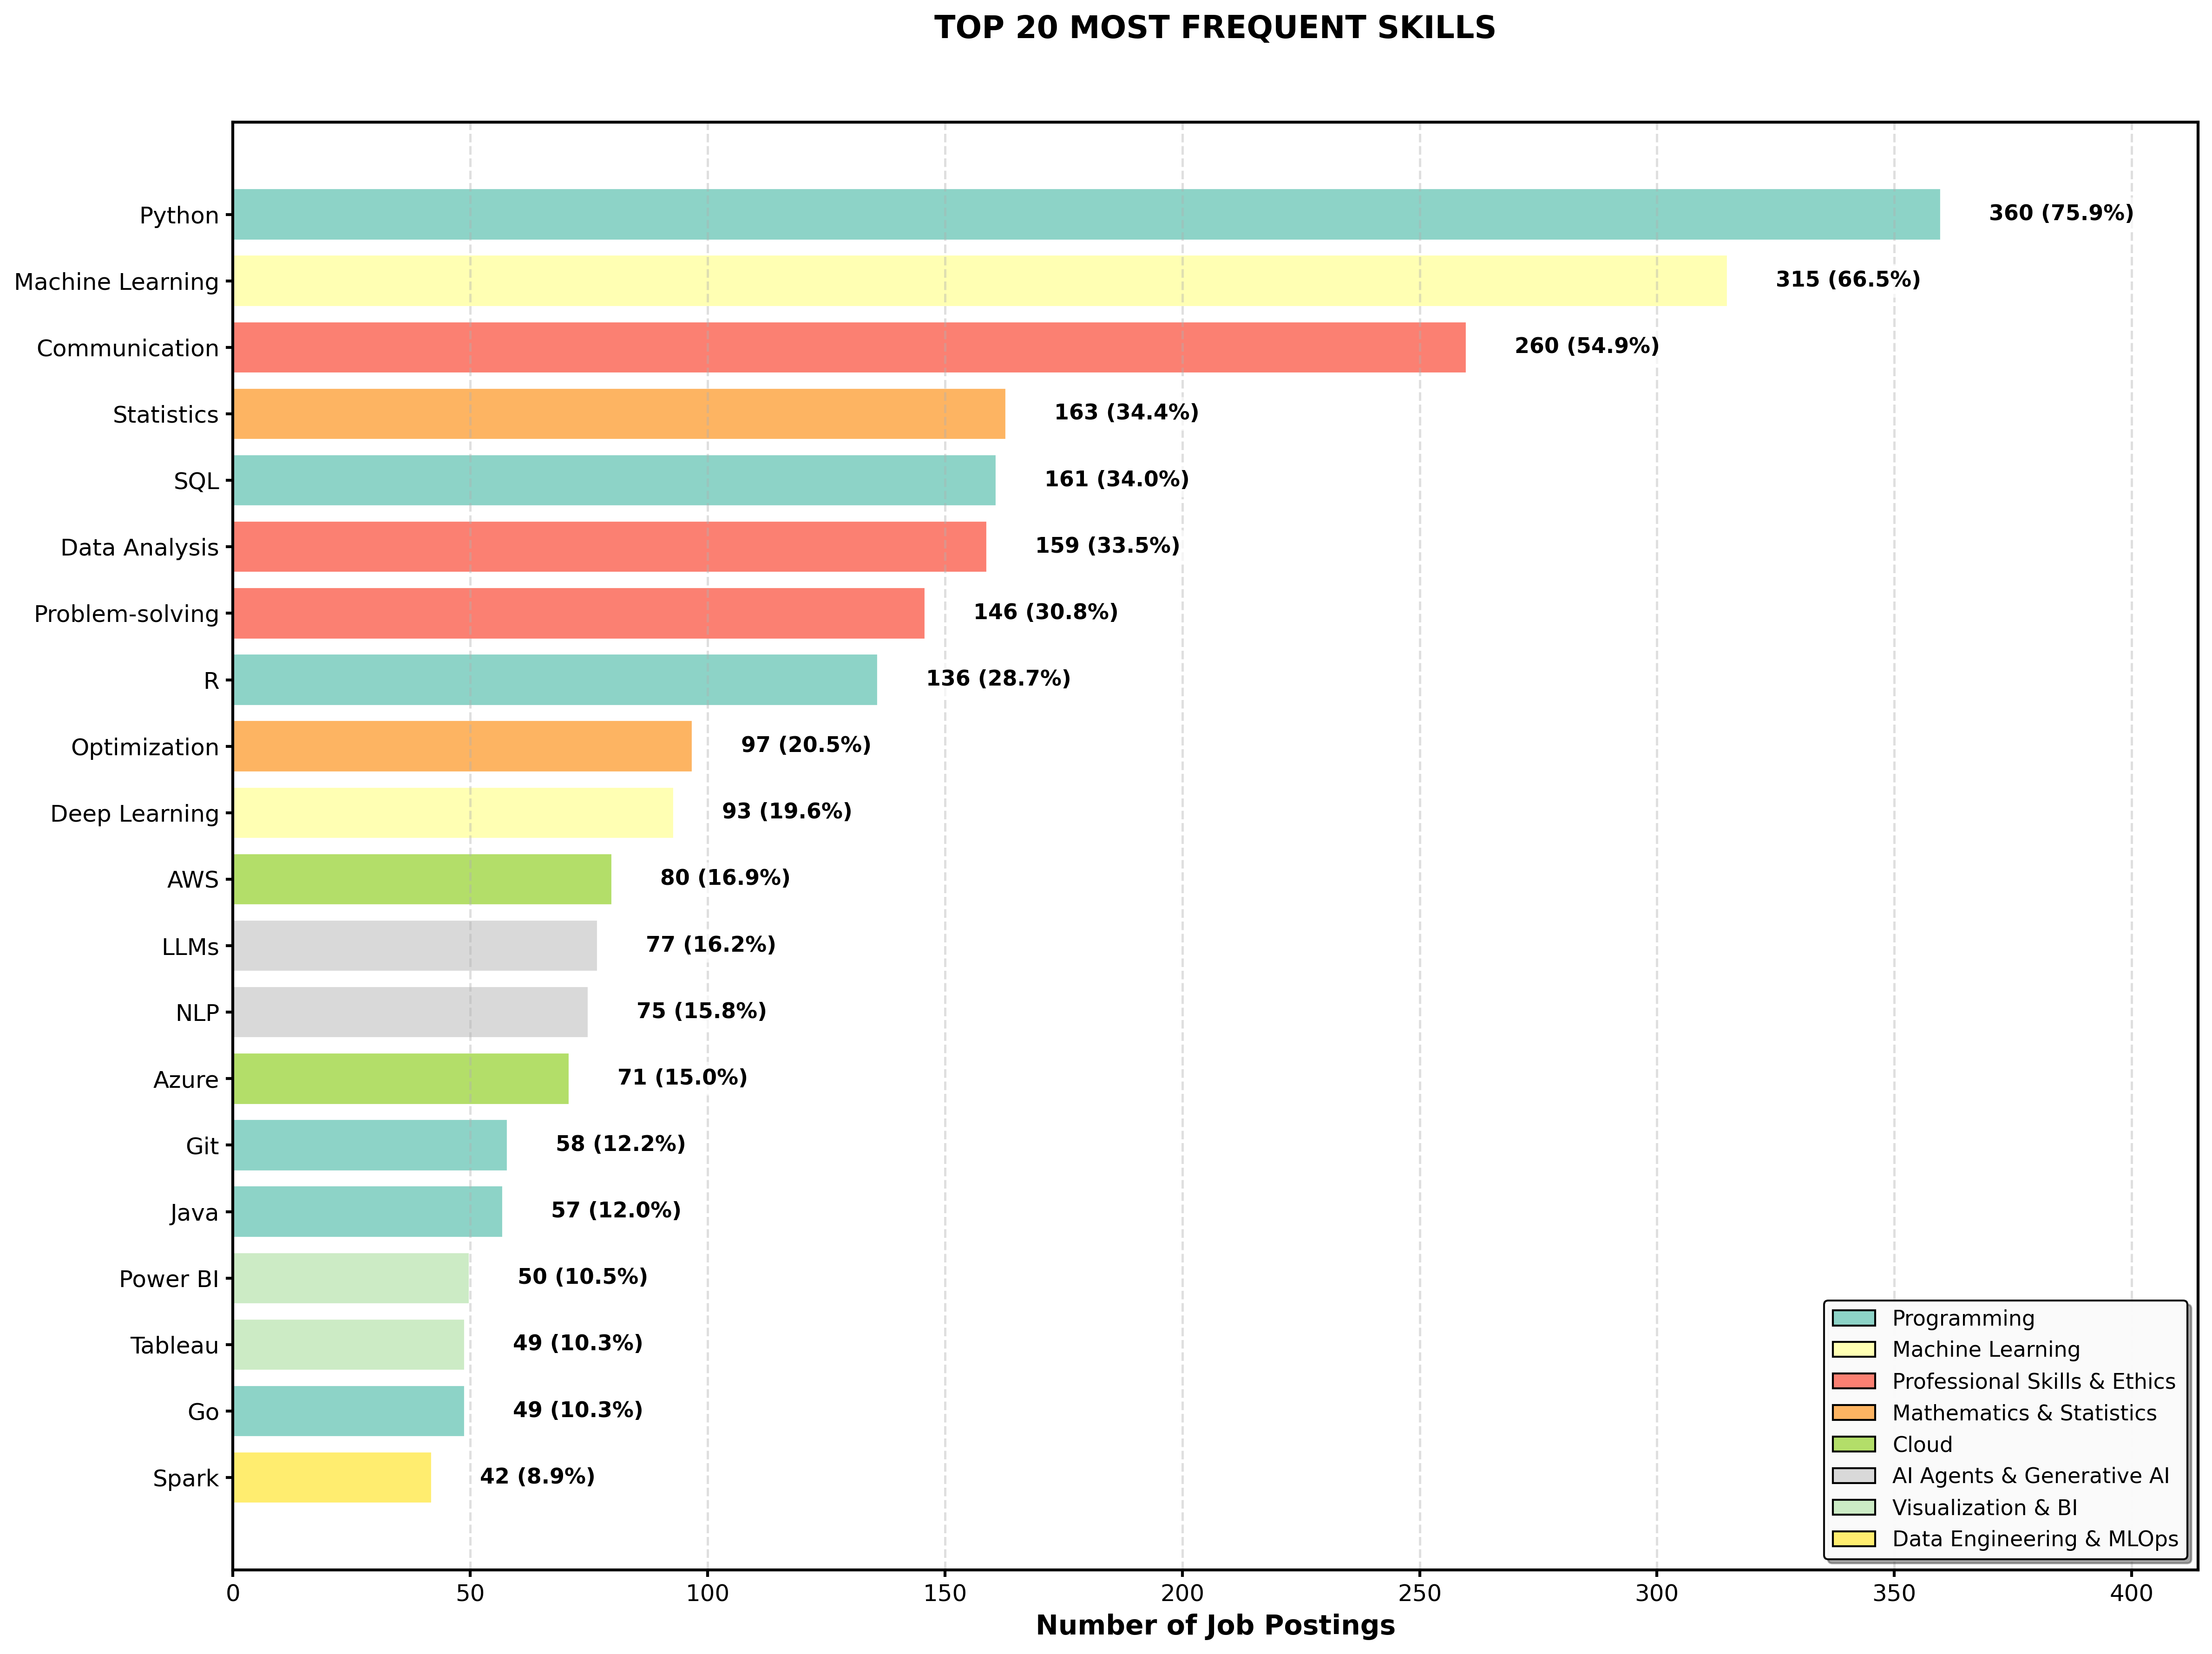

Visualization of TOP 20 MOST FREQUENT SKILLS (colored by category) created!


In [54]:
# ============================================================================
# SECTION 5: VISUALIZATION - TOP 20 SKILLS
# ============================================================================

import numpy as np

# Set high-quality rendering parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['grid.linewidth'] = 1.0

# Create a single bar chart colored by category with larger figure size
fig, ax = plt.subplots(figsize=(16, 12))

# Sort by count descending for the main chart
top_20_df_desc = skill_df.head(20).copy()
top_20_df_desc = top_20_df_desc.sort_values('Count', ascending=False)

# Create color map based on category
category_colors = {}
unique_categories = top_20_df_desc['Category'].unique()
color_palette = plt.cm.Set3(np.linspace(0, 1, len(unique_categories)))
for i, cat in enumerate(unique_categories):
    category_colors[cat] = color_palette[i]

bar_colors = [category_colors[cat] for cat in top_20_df_desc['Category']]

bars = ax.barh(range(len(top_20_df_desc)), top_20_df_desc['Count'], color=bar_colors, 
               edgecolor='white', linewidth=1.5)
ax.set_yticks(range(len(top_20_df_desc)))
ax.set_yticklabels(top_20_df_desc['Skill'], fontsize=12, fontweight='medium')
ax.set_xlabel('Number of Job Postings', fontsize=14, fontweight='bold')
ax.set_title('TOP 20 MOST FREQUENT SKILLS\n', fontsize=16, fontweight='bold', pad=25)
ax.grid(axis='x', alpha=0.4, linestyle='--', linewidth=1.2)
ax.set_xlim(0, top_20_df_desc['Count'].max() * 1.15)
ax.invert_yaxis()  # Invert to show highest at top

# Improve tick labels
ax.tick_params(axis='x', labelsize=12, width=1.5)
ax.tick_params(axis='y', labelsize=12, width=1.5)

# Add value labels on bars with better formatting
for i, (idx, row) in enumerate(top_20_df_desc.iterrows()):
    ax.text(row['Count'] + 10, i, f"{int(row['Count'])} ({row['Percentage']:.1f}%)", 
            va='center', fontsize=11, fontweight='bold', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

# Add category legend with better formatting
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=category_colors[cat], label=cat, edgecolor='black', linewidth=1) 
                   for cat in unique_categories]
ax.legend(handles=legend_elements, loc='lower right', fontsize=11, framealpha=0.95, 
          edgecolor='black', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()

# Save as JPG in outputs folder
import os
output_path = '../outputs/top_20_skills_by_category.jpg'
os.makedirs('../outputs', exist_ok=True)

# Save as JPG with high quality
plt.savefig(output_path, format='jpg', bbox_inches='tight', dpi=300, 
            facecolor='white', edgecolor='none', pad_inches=0.2)
print(f"Visualization saved as JPG: {output_path}")

plt.show()

print("Visualization of TOP 20 MOST FREQUENT SKILLS (colored by category) created!")


In [47]:
# ============================================================================
# SECTION 9: MONTHLY TRENDS ANALYSIS
# ============================================================================

# Get top 20 skills for trend analysis
top_20_skills = skill_df.head(20)['Skill'].tolist()
print(f"Analyzing monthly trends for top 20 skills: {top_20_skills}\n")

# Ensure Posted_Date is datetime and create a month column
df['Posted_Date'] = pd.to_datetime(df['Posted_Date'], errors='coerce')
df['Year_Month'] = df['Posted_Date'].dt.to_period('M')
df['Year_Month_str'] = df['Posted_Date'].dt.strftime('%Y-%m')

# Remove rows with null dates
df_clean = df.dropna(subset=['Posted_Date', 'Year_Month']).copy()

print(f"Jobs with valid dates: {len(df_clean)}")
print(f"Date range: {df_clean['Posted_Date'].min()} to {df_clean['Posted_Date'].max()}")
print(f"Month range: {df_clean['Year_Month'].min()} to {df_clean['Year_Month'].max()}\n")

# Helper function (reuse)
def check_skill_in_description(description, skill):
    return check_skill_in_text(description, skill)

# Create a dictionary to store monthly counts for each skill
monthly_trends = {}

# For each top 20 skill, count occurrences by month
for skill in top_20_skills:
    monthly_counts = []
    
    # Group by month and count occurrences
    for month in sorted(df_clean['Year_Month'].unique()):
        month_data = df_clean[df_clean['Year_Month'] == month]
        descriptions = month_data['Full_Description'].fillna('').astype(str)
        
        # Count how many job descriptions contain this skill
        count = descriptions.apply(lambda desc: check_skill_in_description(desc, skill)).sum()
        total_jobs = len(month_data)
        percentage = (count / total_jobs * 100) if total_jobs > 0 else 0
        
        monthly_counts.append({
            'Year_Month': str(month),
            'Year_Month_str': month_data['Year_Month_str'].iloc[0] if len(month_data) > 0 else str(month),
            'Count': count,
            'Total_Jobs': total_jobs,
            'Percentage': percentage
        })
    
    monthly_trends[skill] = pd.DataFrame(monthly_counts)

# Create a combined DataFrame for all top 20 skills
trend_data_list = []
for skill in top_20_skills:
    skill_trend = monthly_trends[skill].copy()
    skill_trend['Skill'] = skill
    trend_data_list.append(skill_trend)

trend_df = pd.concat(trend_data_list, ignore_index=True)

# Display summary table
print("=" * 100)
print("MONTHLY TRENDS FOR TOP 20 SKILLS")
print("=" * 100)

# Pivot table: skills as rows, months as columns, values as counts
pivot_counts = trend_df.pivot_table(
    index='Skill', 
    columns='Year_Month_str', 
    values='Count', 
    fill_value=0
)

# Reorder columns by date
pivot_counts = pivot_counts.reindex(sorted(pivot_counts.columns), axis=1)

print("\nCount of job postings mentioning each skill by month:")
print(pivot_counts.to_string())

# Pivot table for percentages
pivot_percentages = trend_df.pivot_table(
    index='Skill', 
    columns='Year_Month_str', 
    values='Percentage', 
    fill_value=0
)

# Reorder columns by date
pivot_percentages = pivot_percentages.reindex(sorted(pivot_percentages.columns), axis=1)

print("\n\nPercentage of job postings mentioning each skill by month:")
print(pivot_percentages.round(2).to_string())

# Summary statistics by skill
print("\n" + "=" * 100)
print("TREND SUMMARY STATISTICS")
print("=" * 100)

trend_summary = []
for skill in top_20_skills:
    skill_data = trend_df[trend_df['Skill'] == skill]
    trend_summary.append({
        'Skill': skill,
        'Total_Months': len(skill_data),
        'Avg_Count_Per_Month': skill_data['Count'].mean(),
        'Max_Count': skill_data['Count'].max(),
        'Min_Count': skill_data['Count'].min(),
        'Avg_Percentage': skill_data['Percentage'].mean(),
        'Trend_Last_3_Months': skill_data.tail(3)['Count'].mean() if len(skill_data) >= 3 else skill_data['Count'].mean(),
        'Trend_First_3_Months': skill_data.head(3)['Count'].mean() if len(skill_data) >= 3 else skill_data['Count'].mean()
    })

trend_summary_df = pd.DataFrame(trend_summary)
trend_summary_df['Change_Rate'] = ((trend_summary_df['Trend_Last_3_Months'] - trend_summary_df['Trend_First_3_Months']) / 
                                   (trend_summary_df['Trend_First_3_Months'] + 1) * 100)
trend_summary_df = trend_summary_df.sort_values('Avg_Count_Per_Month', ascending=False)

print("\nTrend Summary (sorted by average count per month):")
print(trend_summary_df.to_string(index=False))


Analyzing monthly trends for top 20 skills: ['Python', 'Machine Learning', 'Communication', 'Statistics', 'SQL', 'Data Analysis', 'Problem-solving', 'R', 'Optimization', 'Deep Learning', 'AWS', 'LLMs', 'NLP', 'Azure', 'Git', 'Java', 'Power BI', 'Tableau', 'Go', 'Spark']

Jobs with valid dates: 474
Date range: 2024-11-22 17:12:56.219000+00:00 to 2025-12-17 12:53:19.602000+00:00
Month range: 2024-11 to 2025-12



C:\Users\nhphuong\AppData\Local\Temp\ipykernel_91224\498791823.py:11: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Year_Month'] = df['Posted_Date'].dt.to_period('M')


MONTHLY TRENDS FOR TOP 20 SKILLS

Count of job postings mentioning each skill by month:
Year_Month_str    2024-11  2024-12  2025-01  2025-02  2025-03  2025-04  2025-05  2025-06  2025-07  2025-08  2025-09  2025-10  2025-11  2025-12
Skill                                                                                                                                         
AWS                   2.0      0.0      0.0      0.0      0.0      0.0      1.0      0.0      0.0      3.0     17.0     10.0     22.0     25.0
Azure                 2.0      0.0      0.0      0.0      1.0      0.0      1.0      0.0      0.0      2.0     16.0     10.0     22.0     17.0
Communication         4.0      1.0      2.0      0.0      1.0      0.0      2.0      0.0      6.0     17.0     37.0     40.0     69.0     81.0
Data Analysis         0.0      1.0      1.0      1.0      0.0      1.0      0.0      0.0      0.0      3.0     20.0     22.0     33.0     34.0
Deep Learning         1.0      0.0      0.0      0.0  

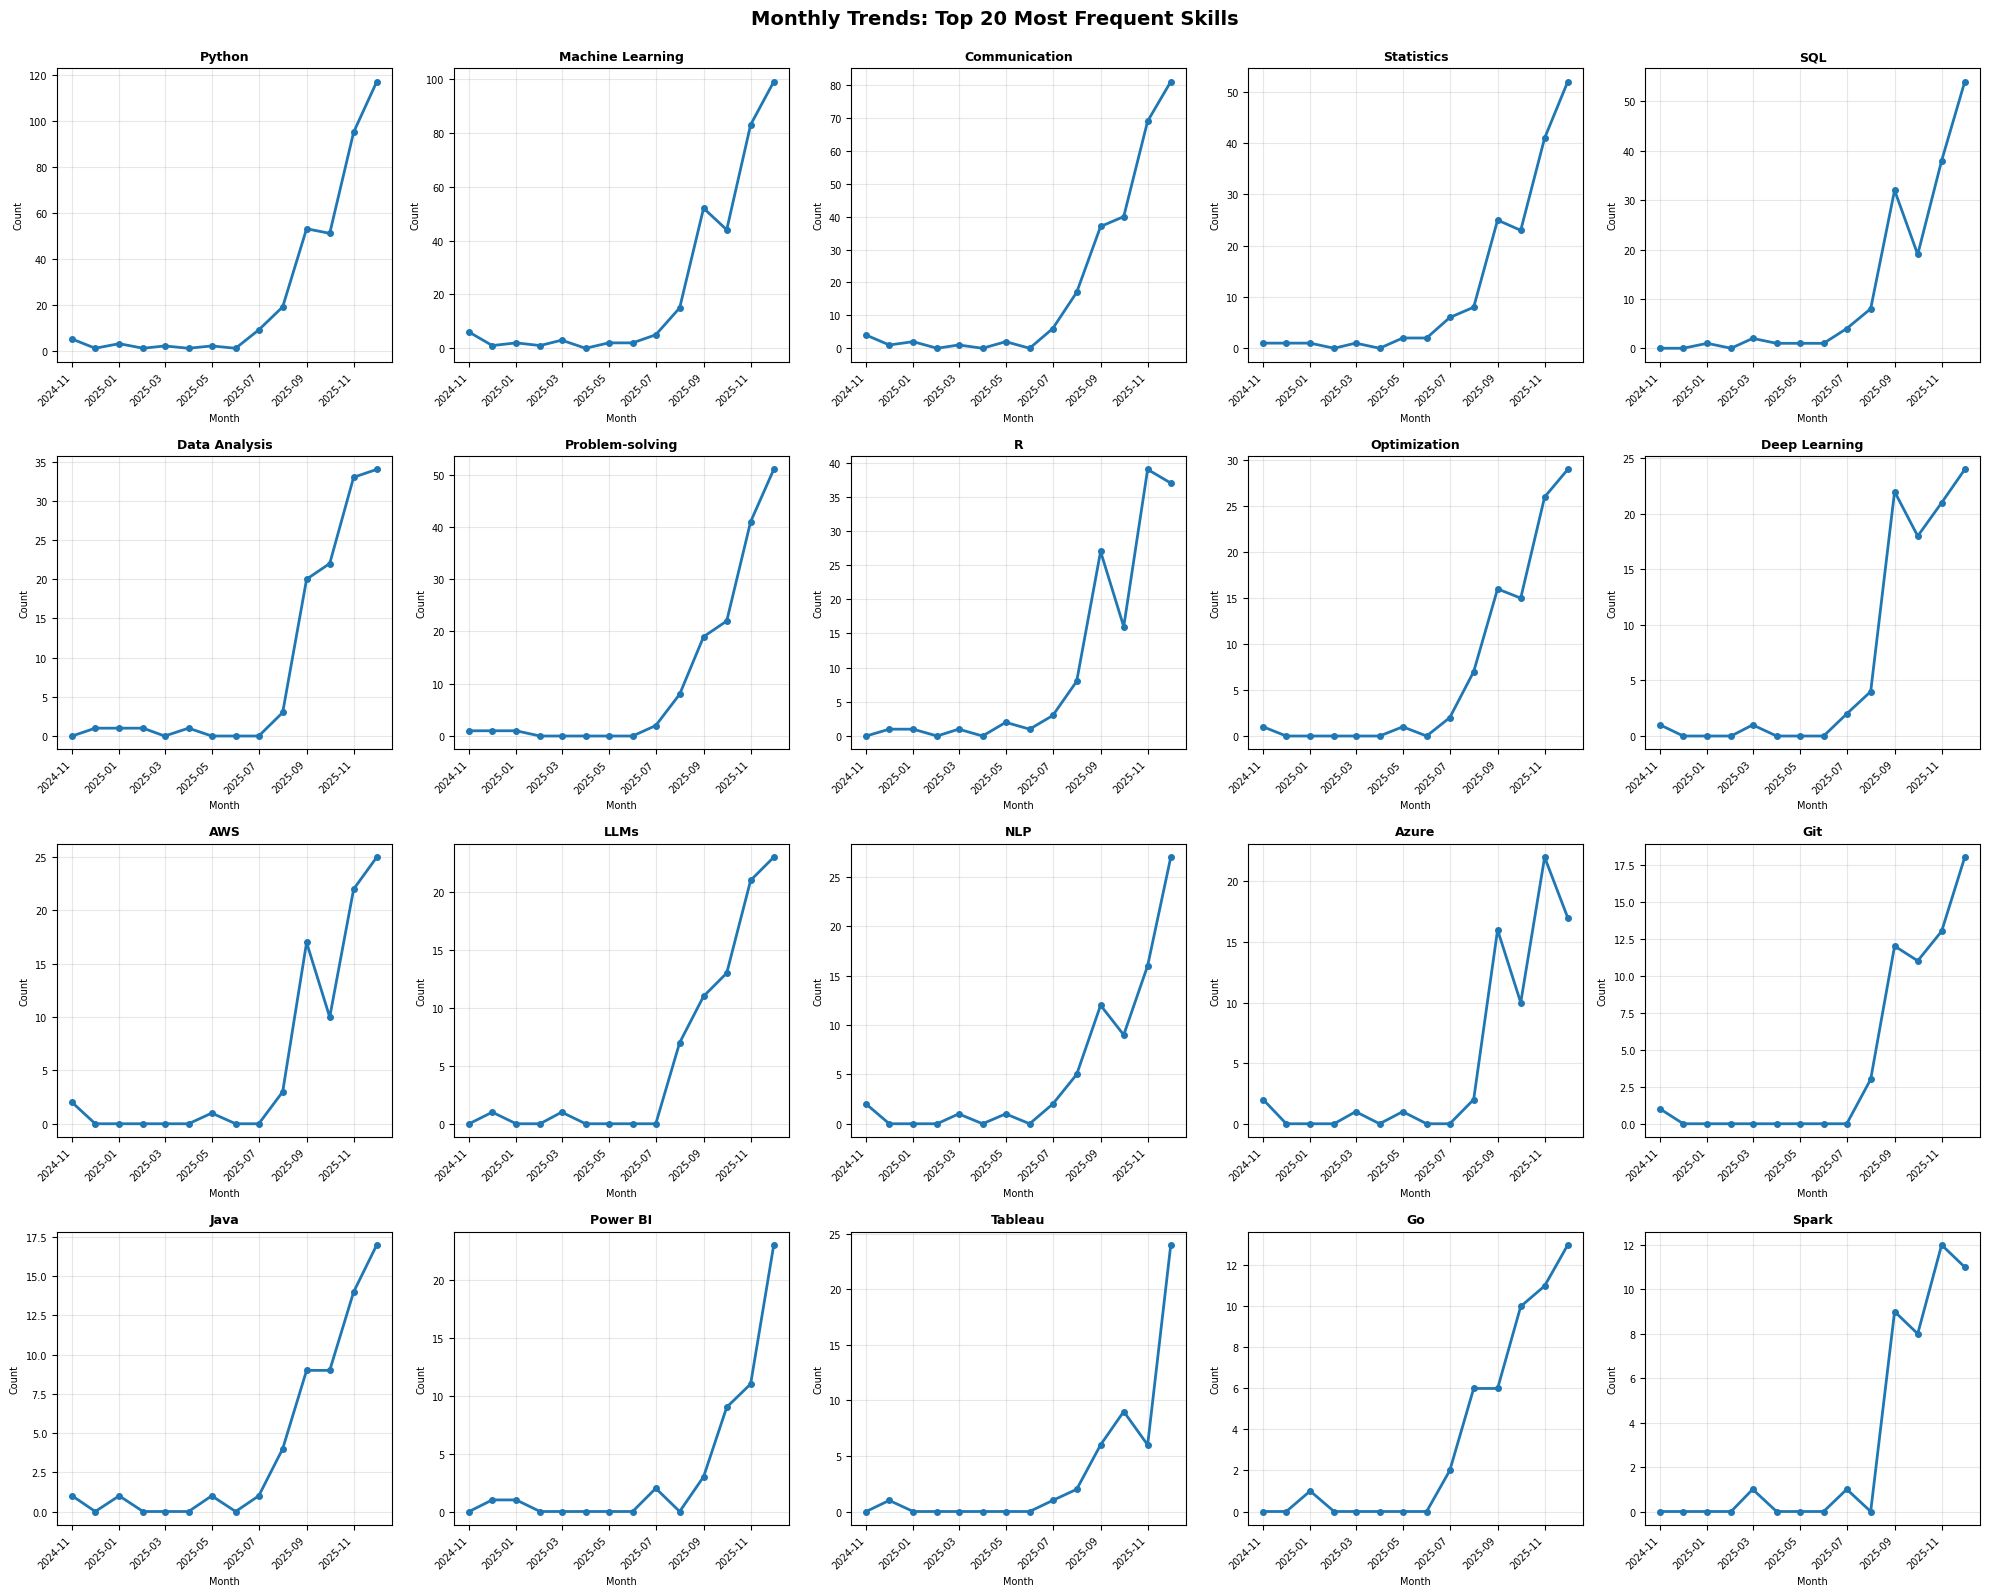

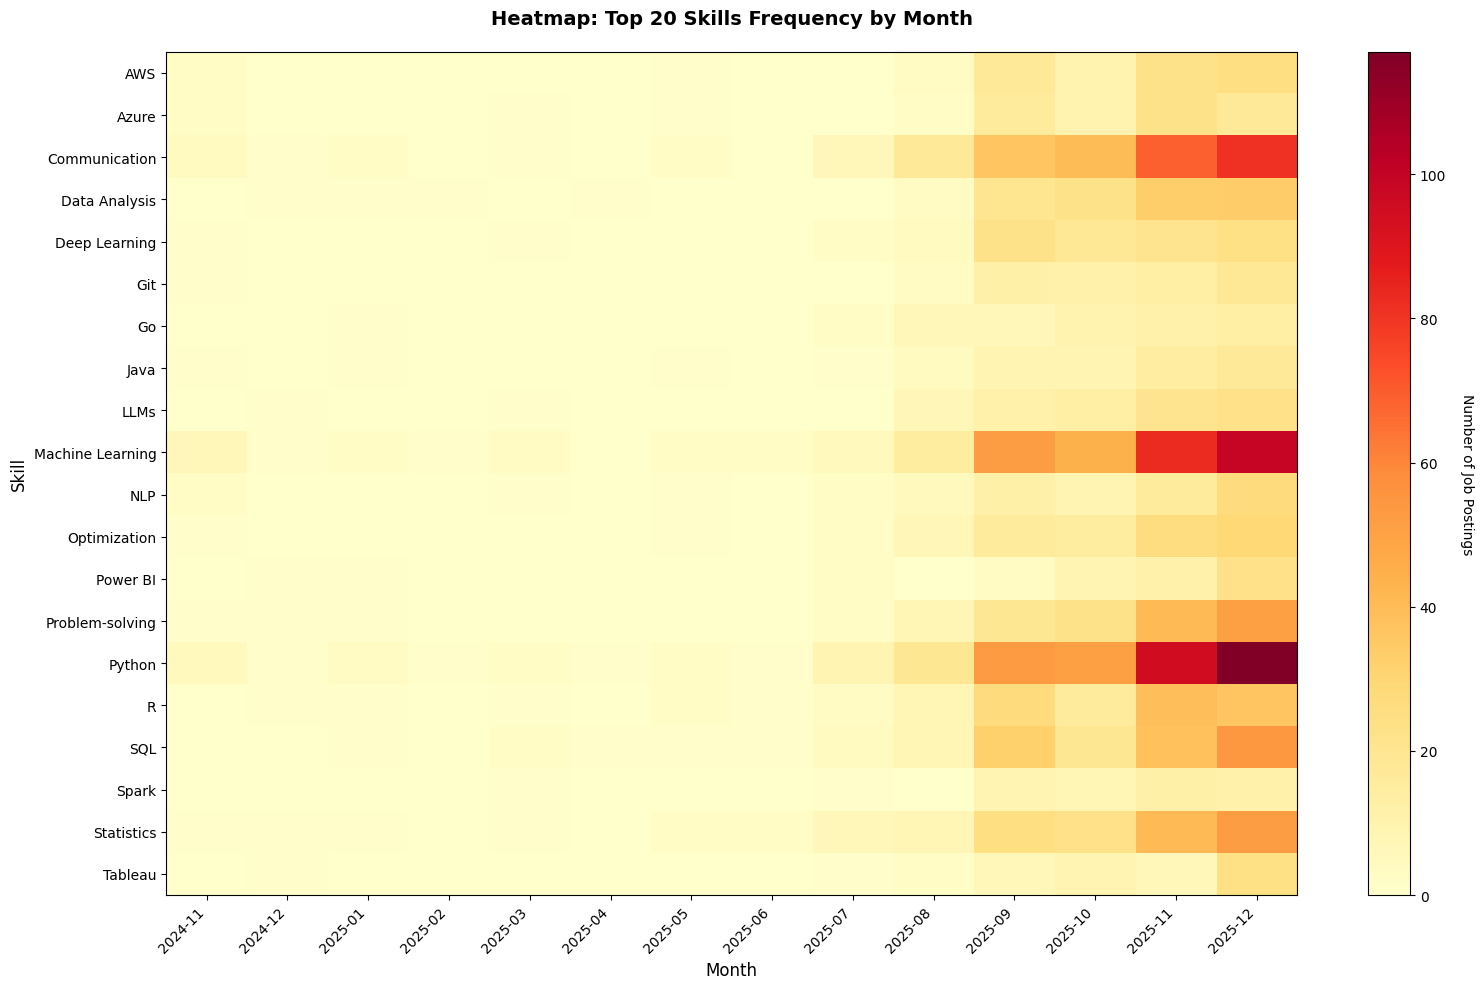

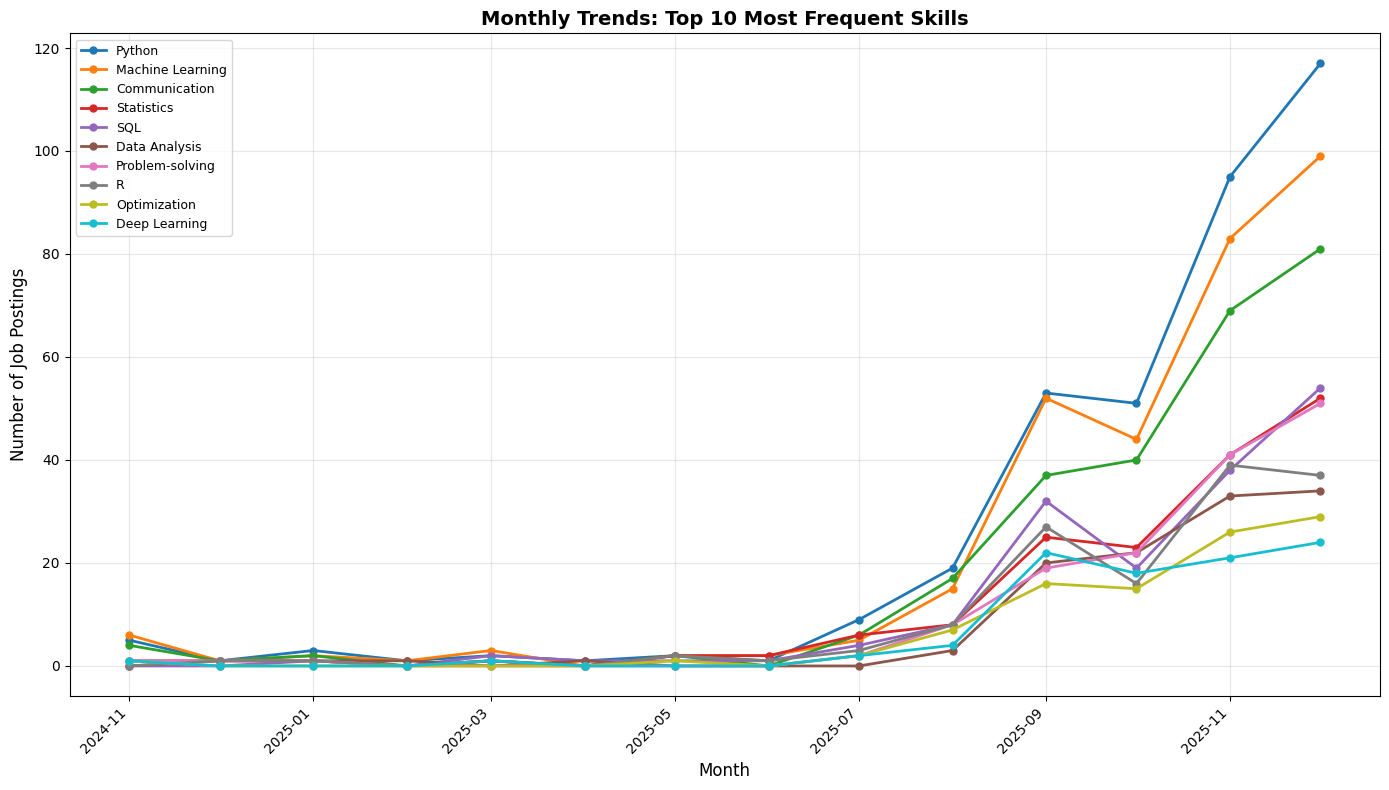


Visualizations created!


In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Set up the plotting style
plt.style.use('default')
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

# Convert Year_Month_str to datetime for plotting
trend_df['Date'] = pd.to_datetime(trend_df['Year_Month_str'] + '-01')

# Plot each skill
for idx, skill in enumerate(top_20_skills):
    skill_data = trend_df[trend_df['Skill'] == skill].sort_values('Date')
    
    ax = axes[idx]
    ax.plot(skill_data['Date'], skill_data['Count'], marker='o', linewidth=2, markersize=4)
    ax.set_title(skill, fontsize=9, fontweight='bold')
    ax.set_xlabel('Month', fontsize=7)
    ax.set_ylabel('Count', fontsize=7)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=7)
    
    # Format x-axis dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle('Monthly Trends: Top 20 Most Frequent Skills', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Create a heatmap visualization
fig, ax = plt.subplots(figsize=(16, 10))

# Prepare data for heatmap (skills vs months)
heatmap_data = pivot_counts.copy()
heatmap_data.index.name = 'Skill'

# Create heatmap
im = ax.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')

# Set ticks and labels
ax.set_xticks(range(len(heatmap_data.columns)))
ax.set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
ax.set_yticks(range(len(heatmap_data.index)))
ax.set_yticklabels(heatmap_data.index)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Number of Job Postings', rotation=270, labelpad=20)

ax.set_title('Heatmap: Top 20 Skills Frequency by Month', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Skill', fontsize=12)

plt.tight_layout()
plt.show()

# Line plot for top 10 skills (for better readability)
fig, ax = plt.subplots(figsize=(14, 8))

top_10_skills = top_20_skills[:10]
for skill in top_10_skills:
    skill_data = trend_df[trend_df['Skill'] == skill].sort_values('Date')
    ax.plot(skill_data['Date'], skill_data['Count'], marker='o', linewidth=2, label=skill, markersize=5)

ax.set_title('Monthly Trends: Top 10 Most Frequent Skills', fontsize=14, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Job Postings', fontsize=12)
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\nVisualizations created!")


In [49]:
# ============================================================================
# SECTION 8: COMPANY ANALYSIS
# ============================================================================

print("=" * 80)
print("COMPANY ANALYSIS")
print("=" * 80)

# Basic statistics
total_jobs = len(df)
unique_companies = df['Company_Name'].nunique()
null_companies = df['Company_Name'].isna().sum()

print(f"\nTotal job postings: {total_jobs}")
print(f"Unique companies: {unique_companies}")
print(f"Null/empty company names: {null_companies}")
print(f"Companies with valid names: {total_jobs - null_companies}")

# Companies with most job postings
company_counts = df['Company_Name'].value_counts()
print(f"\n" + "=" * 80)
print("TOP 20 COMPANIES BY NUMBER OF JOB POSTINGS")
print("=" * 80)
print(company_counts.head(20).to_string())

# Statistics about company distribution
print(f"\n" + "=" * 80)
print("COMPANY DISTRIBUTION STATISTICS")
print("=" * 80)
print(f"Companies with 1 job posting: {(company_counts == 1).sum()}")
print(f"Companies with 2-5 job postings: {((company_counts >= 2) & (company_counts <= 5)).sum()}")
print(f"Companies with 6-10 job postings: {((company_counts >= 6) & (company_counts <= 10)).sum()}")
print(f"Companies with 11-20 job postings: {((company_counts >= 11) & (company_counts <= 20)).sum()}")
print(f"Companies with 21+ job postings: {(company_counts >= 21).sum()}")

# Percentage of jobs from top companies
top_10_companies_jobs = company_counts.head(10).sum()
top_20_companies_jobs = company_counts.head(20).sum()
print(f"\nTop 10 companies account for: {top_10_companies_jobs} jobs ({top_10_companies_jobs/total_jobs*100:.2f}%)")
print(f"Top 20 companies account for: {top_20_companies_jobs} jobs ({top_20_companies_jobs/total_jobs*100:.2f}%)")

# Create a DataFrame for better analysis
company_df = pd.DataFrame({
    'Company_Name': company_counts.index,
    'Job_Count': company_counts.values,
    'Percentage': (company_counts.values / total_jobs * 100)
}).reset_index(drop=True)

print(f"\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"Number of different companies in the dataset: {unique_companies}")
print(f"Average jobs per company: {company_counts.mean():.2f}")
print(f"Median jobs per company: {company_counts.median():.2f}")
print(f"Max jobs from a single company: {company_counts.max()}")


COMPANY ANALYSIS

Total job postings: 474
Unique companies: 339
Null/empty company names: 0
Companies with valid names: 474

TOP 20 COMPANIES BY NUMBER OF JOB POSTINGS
Company_Name
AbbVie                                            7
Adobe                                             7
TikTok                                            7
Seagate Technology                                5
Corsair                                           5
Johns Hopkins Applied Physics Laboratory (APL)    5
Intercontinental Exchange Holdings, Inc.          5
ZS                                                5
MidAmerican Energy Company                        5
ByteDance                                         5
CVS Health                                        5
KLA                                               4
Waymo                                             4
Samsung Research America Internship               4
Gilead Sciences                                   4
Genentech                              

In [50]:
# ============================================================================
# SECTION 7: SKILL COMPARISONS
# ============================================================================

# Comparison 1: R vs Python
print("=" * 80)
print("R AND PYTHON ANALYSIS")
print("=" * 80)

# Helper function (reuse)
def check_skill(description, skill):
    return check_skill_in_text(description, skill)

# Check for Python and R mentions
descriptions = df['Full_Description'].fillna('').astype(str)
has_python = descriptions.apply(lambda desc: check_skill(desc, 'Python'))
has_r = descriptions.apply(lambda desc: check_skill(desc, 'R'))

# Create combinations
both_r_python = has_python & has_r
only_python = has_python & ~has_r
only_r = has_r & ~has_python
neither = ~has_python & ~has_r

# Count each category
total_jobs = len(df)
count_both = both_r_python.sum()
count_only_python = only_python.sum()
count_only_r = only_r.sum()
count_neither = neither.sum()

print(f"\nTotal job postings: {total_jobs}")
print(f"\n" + "-" * 80)
print("BREAKDOWN:")
print("-" * 80)
print(f"Jobs mentioning BOTH R and Python: {count_both} ({count_both/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY Python (not R): {count_only_python} ({count_only_python/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY R (not Python): {count_only_r} ({count_only_r/total_jobs*100:.2f}%)")
print(f"Jobs mentioning NEITHER R nor Python: {count_neither} ({count_neither/total_jobs*100:.2f}%)")

print(f"\n" + "-" * 80)
print("SUMMARY:")
print("-" * 80)
print(f"Jobs mentioning Python (with or without R): {has_python.sum()} ({has_python.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning R (with or without Python): {has_r.sum()} ({has_r.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning either Python OR R: {(has_python | has_r).sum()} ({(has_python | has_r).sum()/total_jobs*100:.2f}%)")

# Verify the math
print(f"\n" + "-" * 80)
print("VERIFICATION:")
print("-" * 80)
print(f"Both + Only Python + Only R + Neither = {count_both + count_only_python + count_only_r + count_neither}")
print(f"Should equal total: {total_jobs}")

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Category': [
        'Both R and Python',
        'Only Python (not R)',
        'Only R (not Python)',
        'Neither R nor Python',
        'Total'
    ],
    'Count': [
        count_both,
        count_only_python,
        count_only_r,
        count_neither,
        total_jobs
    ],
    'Percentage': [
        count_both/total_jobs*100,
        count_only_python/total_jobs*100,
        count_only_r/total_jobs*100,
        count_neither/total_jobs*100,
        100.0
    ]
})

print(f"\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(summary_df.to_string(index=False))


R AND PYTHON ANALYSIS

Total job postings: 474

--------------------------------------------------------------------------------
BREAKDOWN:
--------------------------------------------------------------------------------
Jobs mentioning BOTH R and Python: 122 (25.74%)
Jobs mentioning ONLY Python (not R): 238 (50.21%)
Jobs mentioning ONLY R (not Python): 14 (2.95%)
Jobs mentioning NEITHER R nor Python: 100 (21.10%)

--------------------------------------------------------------------------------
SUMMARY:
--------------------------------------------------------------------------------
Jobs mentioning Python (with or without R): 360 (75.95%)
Jobs mentioning R (with or without Python): 136 (28.69%)
Jobs mentioning either Python OR R: 374 (78.90%)

--------------------------------------------------------------------------------
VERIFICATION:
--------------------------------------------------------------------------------
Both + Only Python + Only R + Neither = 474
Should equal total: 474

S

In [51]:
# ============================================================================
# SECTION 10: SKILL RANKING BY CATEGORY
# ============================================================================

print("=" * 100)
print("SKILL RANKING BY CATEGORY")
print("=" * 100)

# Calculate category-level statistics
category_stats = []
for category in skills.keys():
    category_skills = skill_df[skill_df['Category'] == category]
    
    if len(category_skills) > 0:
        category_stats.append({
            'Category': category,
            'Total_Skills': len(category_skills),
            'Total_Mentions': category_skills['Count'].sum(),
            'Avg_Mentions_Per_Skill': category_skills['Count'].mean(),
            'Max_Mentions': category_skills['Count'].max(),
            'Min_Mentions': category_skills['Count'].min(),
            'Median_Mentions': category_skills['Count'].median(),
            'Top_Skill': category_skills.loc[category_skills['Count'].idxmax(), 'Skill'],
            'Top_Skill_Count': category_skills['Count'].max(),
            'Skills_with_0_Mentions': (category_skills['Count'] == 0).sum(),
            'Avg_Percentage': category_skills['Percentage'].mean()
        })

category_ranking_df = pd.DataFrame(category_stats)

# Rank categories by different metrics
print("\n" + "=" * 100)
print("CATEGORY RANKING BY TOTAL MENTIONS")
print("=" * 100)
category_ranking_total = category_ranking_df.sort_values('Total_Mentions', ascending=False)
print(category_ranking_total[['Category', 'Total_Mentions', 'Total_Skills', 'Avg_Mentions_Per_Skill', 
                               'Top_Skill', 'Top_Skill_Count']].to_string(index=False))

print("\n" + "=" * 100)
print("CATEGORY RANKING BY AVERAGE MENTIONS PER SKILL")
print("=" * 100)
category_ranking_avg = category_ranking_df.sort_values('Avg_Mentions_Per_Skill', ascending=False)
print(category_ranking_avg[['Category', 'Avg_Mentions_Per_Skill', 'Total_Mentions', 'Total_Skills', 
                            'Top_Skill', 'Top_Skill_Count']].to_string(index=False))

print("\n" + "=" * 100)
print("CATEGORY RANKING BY TOP SKILL COUNT")
print("=" * 100)
category_ranking_top = category_ranking_df.sort_values('Top_Skill_Count', ascending=False)
print(category_ranking_top[['Category', 'Top_Skill', 'Top_Skill_Count', 'Total_Mentions', 
                            'Avg_Mentions_Per_Skill']].to_string(index=False))

# Display skills ranked within each category
print("\n" + "=" * 100)
print("SKILLS RANKED WITHIN EACH CATEGORY")
print("=" * 100)

for category in category_ranking_total['Category']:
    category_skills = skill_df[skill_df['Category'] == category].sort_values('Count', ascending=False)
    
    print(f"\n{'=' * 100}")
    print(f"CATEGORY: {category}")
    print(f"{'=' * 100}")
    print(f"Total Skills: {len(category_skills)} | Total Mentions: {category_skills['Count'].sum()} | "
          f"Avg per Skill: {category_skills['Count'].mean():.2f}")
    print(f"\nRanked Skills:")
    print("-" * 100)
    
    # Add rank column
    category_skills_ranked = category_skills.copy()
    category_skills_ranked['Rank'] = range(1, len(category_skills_ranked) + 1)
    category_skills_ranked = category_skills_ranked[['Rank', 'Skill', 'Count', 'Percentage']]
    
    print(category_skills_ranked.to_string(index=False))

# Summary visualization by category
print("\n" + "=" * 100)
print("CATEGORY SUMMARY STATISTICS")
print("=" * 100)
print(category_ranking_df[['Category', 'Total_Skills', 'Total_Mentions', 'Avg_Mentions_Per_Skill', 
                           'Max_Mentions', 'Median_Mentions', 'Skills_with_0_Mentions']].to_string(index=False))


SKILL RANKING BY CATEGORY

CATEGORY RANKING BY TOTAL MENTIONS
                          Category  Total_Mentions  Total_Skills  Avg_Mentions_Per_Skill        Top_Skill  Top_Skill_Count
                       Programming             899            15               59.933333           Python              360
      Professional Skills & Ethics             628            12               52.333333    Communication              260
                  Machine Learning             505            14               36.071429 Machine Learning              315
         AI Agents & Generative AI             312            17               18.352941             LLMs               77
          Mathematics & Statistics             303            11               27.545455       Statistics              163
                             Cloud             213             7               30.428571              AWS               80
          Data Engineering & MLOps             192            18             

In [52]:
# Comparison 2: AWS vs Azure
print("\n" + "=" * 80)
print("AWS AND AZURE ANALYSIS")
print("=" * 80)

# Helper function (reuse)
def check_skill(description, skill):
    return check_skill_in_text(description, skill)

# Check for AWS and Azure mentions (including aliases)
descriptions = df['Full_Description'].fillna('').astype(str)
# AWS can be "AWS" or "Amazon Web Services"
has_aws = descriptions.apply(lambda desc: check_skill(desc, 'AWS') or check_skill(desc, 'Amazon Web Services'))
# Azure can be "Azure" or "Microsoft Azure"
has_azure = descriptions.apply(lambda desc: check_skill(desc, 'Azure') or check_skill(desc, 'Microsoft Azure'))

# Create combinations
both_aws_azure = has_aws & has_azure
only_aws = has_aws & ~has_azure
only_azure = has_azure & ~has_aws
neither = ~has_aws & ~has_azure

# Count each category
total_jobs = len(df)
count_both = both_aws_azure.sum()
count_only_aws = only_aws.sum()
count_only_azure = only_azure.sum()
count_neither = neither.sum()

print(f"\nTotal job postings: {total_jobs}")
print(f"\n" + "-" * 80)
print("BREAKDOWN:")
print("-" * 80)
print(f"Jobs mentioning BOTH AWS and Azure: {count_both} ({count_both/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY AWS (not Azure): {count_only_aws} ({count_only_aws/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY Azure (not AWS): {count_only_azure} ({count_only_azure/total_jobs*100:.2f}%)")
print(f"Jobs mentioning NEITHER AWS nor Azure: {count_neither} ({count_neither/total_jobs*100:.2f}%)")

print(f"\n" + "-" * 80)
print("SUMMARY:")
print("-" * 80)
print(f"Jobs mentioning AWS (with or without Azure): {has_aws.sum()} ({has_aws.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning Azure (with or without AWS): {has_azure.sum()} ({has_azure.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning either AWS OR Azure: {(has_aws | has_azure).sum()} ({(has_aws | has_azure).sum()/total_jobs*100:.2f}%)")

# Verify the math
print(f"\n" + "-" * 80)
print("VERIFICATION:")
print("-" * 80)
print(f"Both + Only AWS + Only Azure + Neither = {count_both + count_only_aws + count_only_azure + count_neither}")
print(f"Should equal total: {total_jobs}")

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Category': [
        'Both AWS and Azure',
        'Only AWS (not Azure)',
        'Only Azure (not AWS)',
        'Neither AWS nor Azure',
        'Total'
    ],
    'Count': [
        count_both,
        count_only_aws,
        count_only_azure,
        count_neither,
        total_jobs
    ],
    'Percentage': [
        count_both/total_jobs*100,
        count_only_aws/total_jobs*100,
        count_only_azure/total_jobs*100,
        count_neither/total_jobs*100,
        100.0
    ]
})

print(f"\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(summary_df.to_string(index=False))



AWS AND AZURE ANALYSIS

Total job postings: 474

--------------------------------------------------------------------------------
BREAKDOWN:
--------------------------------------------------------------------------------
Jobs mentioning BOTH AWS and Azure: 48 (10.13%)
Jobs mentioning ONLY AWS (not Azure): 32 (6.75%)
Jobs mentioning ONLY Azure (not AWS): 23 (4.85%)
Jobs mentioning NEITHER AWS nor Azure: 371 (78.27%)

--------------------------------------------------------------------------------
SUMMARY:
--------------------------------------------------------------------------------
Jobs mentioning AWS (with or without Azure): 80 (16.88%)
Jobs mentioning Azure (with or without AWS): 71 (14.98%)
Jobs mentioning either AWS OR Azure: 103 (21.73%)

--------------------------------------------------------------------------------
VERIFICATION:
--------------------------------------------------------------------------------
Both + Only AWS + Only Azure + Neither = 474
Should equal total: 4

In [53]:
# Comparison 3: Power BI vs Tableau
print("\n" + "=" * 80)
print("POWER BI AND TABLEAU ANALYSIS")
print("=" * 80)

# Helper function (reuse)
def check_skill(description, skill):
    return check_skill_in_text(description, skill)

# Check for Power BI and Tableau mentions
descriptions = df['Full_Description'].fillna('').astype(str)
has_power_bi = descriptions.apply(lambda desc: check_skill(desc, 'Power BI'))
has_tableau = descriptions.apply(lambda desc: check_skill(desc, 'Tableau'))

# Create combinations
both_power_bi_tableau = has_power_bi & has_tableau
only_power_bi = has_power_bi & ~has_tableau
only_tableau = has_tableau & ~has_power_bi
neither = ~has_power_bi & ~has_tableau

# Count each category
total_jobs = len(df)
count_both = both_power_bi_tableau.sum()
count_only_power_bi = only_power_bi.sum()
count_only_tableau = only_tableau.sum()
count_neither = neither.sum()

print(f"\nTotal job postings: {total_jobs}")
print(f"\n" + "-" * 80)
print("BREAKDOWN:")
print("-" * 80)
print(f"Jobs mentioning BOTH Power BI and Tableau: {count_both} ({count_both/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY Power BI (not Tableau): {count_only_power_bi} ({count_only_power_bi/total_jobs*100:.2f}%)")
print(f"Jobs mentioning ONLY Tableau (not Power BI): {count_only_tableau} ({count_only_tableau/total_jobs*100:.2f}%)")
print(f"Jobs mentioning NEITHER Power BI nor Tableau: {count_neither} ({count_neither/total_jobs*100:.2f}%)")

print(f"\n" + "-" * 80)
print("SUMMARY:")
print("-" * 80)
print(f"Jobs mentioning Power BI (with or without Tableau): {has_power_bi.sum()} ({has_power_bi.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning Tableau (with or without Power BI): {has_tableau.sum()} ({has_tableau.sum()/total_jobs*100:.2f}%)")
print(f"Jobs mentioning either Power BI OR Tableau: {(has_power_bi | has_tableau).sum()} ({(has_power_bi | has_tableau).sum()/total_jobs*100:.2f}%)")

# Verify the math
print(f"\n" + "-" * 80)
print("VERIFICATION:")
print("-" * 80)
print(f"Both + Only Power BI + Only Tableau + Neither = {count_both + count_only_power_bi + count_only_tableau + count_neither}")
print(f"Should equal total: {total_jobs}")

# Create a summary DataFrame
summary_df = pd.DataFrame({
    'Category': [
        'Both Power BI and Tableau',
        'Only Power BI (not Tableau)',
        'Only Tableau (not Power BI)',
        'Neither Power BI nor Tableau',
        'Total'
    ],
    'Count': [
        count_both,
        count_only_power_bi,
        count_only_tableau,
        count_neither,
        total_jobs
    ],
    'Percentage': [
        count_both/total_jobs*100,
        count_only_power_bi/total_jobs*100,
        count_only_tableau/total_jobs*100,
        count_neither/total_jobs*100,
        100.0
    ]
})

print(f"\n" + "=" * 80)
print("SUMMARY TABLE")
print("=" * 80)
print(summary_df.to_string(index=False))



POWER BI AND TABLEAU ANALYSIS

Total job postings: 474

--------------------------------------------------------------------------------
BREAKDOWN:
--------------------------------------------------------------------------------
Jobs mentioning BOTH Power BI and Tableau: 26 (5.49%)
Jobs mentioning ONLY Power BI (not Tableau): 24 (5.06%)
Jobs mentioning ONLY Tableau (not Power BI): 23 (4.85%)
Jobs mentioning NEITHER Power BI nor Tableau: 401 (84.60%)

--------------------------------------------------------------------------------
SUMMARY:
--------------------------------------------------------------------------------
Jobs mentioning Power BI (with or without Tableau): 50 (10.55%)
Jobs mentioning Tableau (with or without Power BI): 49 (10.34%)
Jobs mentioning either Power BI OR Tableau: 73 (15.40%)

--------------------------------------------------------------------------------
VERIFICATION:
--------------------------------------------------------------------------------
Both + Only 